code source:
1. https://www.kaggle.com/code/rodsaldanha/stock-prediction-pytorch/notebook
2. https://www.analyticsvidhya.com/blog/2021/07/understanding-rnn-step-by-step-with-pytorch/
3. https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/
4. https://gist.github.com/karpathy/d4dee566867f8291f086
5. https://www.bilibili.com/video/BV1Qy4y1h7nF/

In [1]:
# Importing libraries. 
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
from torch import nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Dataset
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import datetime

In [2]:
torch.manual_seed(1)
random.seed(0)

## Experiment

### **Linear regression model**

In [3]:
 # Load data
 data = pd.read_csv('IBM.csv')  
 # Convert Date to Date format
 data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

# Crop data to use stock values from 2018 onwards
data = data[data.Date>=datetime.datetime(2018,1,1)]

# Visualization of our data
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,147.705551,148.001907,146.787766,147.466537,116.036736,4395815
1,2018-01-03,150.420654,152.782028,149.455063,151.520081,119.226318,9875914
2,2018-01-04,152.629059,155.181641,152.361374,154.588913,121.641083,7903785
3,2018-01-05,155.296371,155.736145,154.015289,155.344162,122.235382,5434807
4,2018-01-08,155.506699,156.701721,154.588913,156.281067,122.972580,5478425


In [4]:
print(len(data)*0.8)
data[984:]

984.0


,Date,Open,High,Low,Close,Adj Close,Volume
984,2021-11-29,118.620003,119.610001,117.529999,118.500000,112.900734,8949800
985,2021-11-30,117.500000,119.239998,116.449997,117.099998,111.566872,9252700
986,2021-12-01,118.250000,118.930000,116.849998,116.919998,111.395386,5958300
987,2021-12-02,117.370003,117.980003,116.559998,116.900002,111.376343,5267100
988,2021-12-03,117.360001,119.360001,117.360001,118.839996,113.224663,6630100
...,...,...,...,...,...,...,...
1225,2022-11-11,141.500000,144.130005,140.960007,143.169998,143.169998,5869400
1226,2022-11-14,142.630005,146.080002,142.179993,144.199997,144.199997,5293500
1227,2022-11-15,144.080002,146.160004,142.000000,144.339996,144.339996,4727100
1228,2022-11-16,144.130005,144.949997,144.009995,144.520004,144.520004,3445200


In [5]:
# Split data in training and test
data_train = data[data.Date<datetime.datetime(2021,11,29)]
data_test = data[data.Date>=datetime.datetime(2021,11,29)]

In [6]:
# Define min max scaler
scaler = MinMaxScaler(feature_range=(0,1))
# Scale data
data_train['Scaled Close'] = scaler.fit_transform(data_train[['Close']])
# Also, scale test data
data_test['Scaled Close'] = scaler.transform(data_test[['Close']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
train_values =  data_train[['Date','Scaled Close']]
test_values =  data_test[['Date','Scaled Close']]

In [8]:
# Define a sequence length
sequence_length = 60

# We go to create an array with our X and y values
previous_days_train = []
current_day_train = []

for x in range(len(train_values)-sequence_length):
  previous_days_train.append(train_values[['Scaled Close']][x:x+sequence_length].values)
  current_day_train.append(train_values[['Scaled Close']].values[x+sequence_length])

previous_days_train = np.array(previous_days_train)
previous_days_train = np.reshape(previous_days_train,(-1,sequence_length))

current_day_train = np.array(current_day_train)
current_day_train = current_day_train.reshape((-1))

In [9]:
current_day_train[0]

0.788971085901472

In [10]:
previous_days_train[0]

array([0.79999995, 0.85702762, 0.90020177, 0.91082706, 0.924008  ,
       0.92885008, 0.93355757, 0.93382655, 0.91956948, 0.92911906,
       0.99367861, 1.        , 0.90921317, 0.91230657, 0.96139873,
       0.94956292, 0.95090782, 0.97605918, 0.96879625, 0.92602546,
       0.9271016 , 0.90961675, 0.86429053, 0.77686607, 0.8146604 ,
       0.79462012, 0.71042365, 0.73624757, 0.76166767, 0.75292525,
       0.80685951, 0.82367179, 0.82595825, 0.81223934, 0.79609963,
       0.78560849, 0.81708145, 0.85823813, 0.83093472, 0.82125076,
       0.79408194, 0.80322795, 0.83631478, 0.81977125, 0.85474116,
       0.82636182, 0.86805648, 0.88083383, 0.86819107, 0.85205113,
       0.87209141, 0.88083383, 0.84169461, 0.82622723, 0.8328178 ,
       0.77094827, 0.7279085 , 0.78816414, 0.76852722, 0.77673169])

In [11]:
# We go to create an array with our X and y values
previous_days_test = []
current_day_test = []

for x in range(len(test_values)-sequence_length):
  previous_days_test.append(test_values[['Scaled Close']][x:x+sequence_length].values)
  current_day_test.append(test_values[['Scaled Close']].values[x+sequence_length])

previous_days_test = np.array(previous_days_test)
previous_days_test = np.reshape(previous_days_test,(-1,sequence_length))

current_day_test = np.array(current_day_test)
current_day_test = current_day_test.reshape((-1))

In [12]:
reg_model = LinearRegression().fit(previous_days_train, current_day_train)

In [13]:
pred_training =  reg_model.predict(previous_days_train)
pred_testing  =  reg_model.predict(previous_days_test)

In [14]:
# Getting MSE
error_mean_train = round(np.mean(np.square(data_train[['Open']][sequence_length:].values- scaler.inverse_transform(pred_training.reshape(-1, 1)))),2) / len(data_train)
print('Mean Squared Error in training: ', str(error_mean_train))
error_mean_test = round(np.mean(np.square(scaler.inverse_transform(pred_testing.reshape(-1, 1))- data_test[['Open']][sequence_length:].values)),2) / len(data_test)
print('Mean Squared Error in testing: ', str(error_mean_test))

Mean Squared Error in training:  0.0020528455284552845
Mean Squared Error in testing:  0.006463414634146342


[]

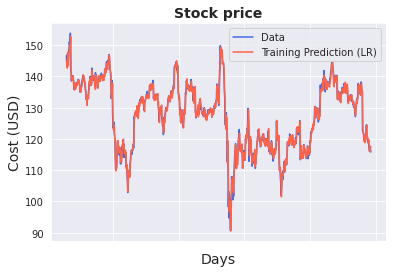

In [15]:
sns.set_style("darkgrid") 
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)
ax = sns.lineplot(x = data_train['Date'][sequence_length:].index, y = data_train['Close'][sequence_length:], label="Data", color='royalblue')
ax = sns.lineplot(x = data_train['Date'][sequence_length:].index, y = scaler.inverse_transform(pred_training.reshape(-1, 1)).reshape(-1), label="Training Prediction (LR)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

[]

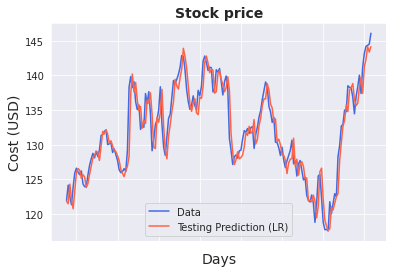

In [16]:
sns.set_style("darkgrid") 
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)
ax = sns.lineplot(x = data_test['Date'][sequence_length:].index, y = data_test['Close'][sequence_length:], label="Data", color='royalblue')
ax = sns.lineplot(x =data_test['Date'][sequence_length:].index, y = scaler.inverse_transform(pred_testing.reshape(-1, 1)).reshape(-1), label="Testing Prediction (LR)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)